# 對比學習訓練資料 測試資料自行分類

# Import Packages & Load data 

In [ ]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



In [34]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.1, stratify=data['Category'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Category'], random_state=42)

print(f"訓練集大小: {len(train_data)}")
print(f"驗證集大小: {len(val_data)}")
print(f"測試集大小: {len(test_data)}")

訓練集大小: 360
驗證集大小: 90
測試集大小: 50


In [35]:
train_data_list = list(train_data['File Path'])
train_labels = list(train_data['Category'])
valid_data_list = list(val_data['File Path'])
valid_labels = list(val_data['Category'])

In [36]:
class_names = list(set(train_labels))
label_mapping = {name: idx for idx, name in enumerate(class_names)}

# CustomImageDataset

`cv2.GaussianBlur` 高斯模糊: 將圖像中的每個像素與周圍像素進行加權平均，達到去除噪聲和平滑圖像的效果。

In [37]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, label_map, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        label = self.label_map[self.labels[idx]]
        img = cv2.imread(self.image_paths[idx])

        # 圖像處理步驟
        img = cv2.resize(img, (224, 224))
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray_img, (5, 5), 0)
        retval, binary_img = cv2.threshold(blur, 240, 255, cv2.THRESH_OTSU)
        processed_img = 255 - binary_img
        processed_img = cv2.cvtColor(processed_img, cv2.COLOR_GRAY2RGB)
        
        # 将填充后的图像转换回 PIL 格式
        filled_image_pil = Image.fromarray(processed_img)
        # 应用其他转换
        if self.transform:
            filled_image_pil = self.transform(filled_image_pil)

        return filled_image_pil, label


### Transform

In [38]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomImageDataset(train_data_list, train_labels, label_mapping ,transform=train_transform)
val_dataset = CustomImageDataset(valid_data_list, valid_labels, label_mapping ,transform=transform)

## 對比學習比對樣本

`ContrastiveCategoryDataset`: 從同一類別中挑選具有高變異度的樣本對，使模型能更有效地學習區分特徵。

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random


class ContrastiveCategoryDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
        # 將圖片按類別整理
        self.class_to_idx = {}
        for idx, (_, label) in enumerate(self.dataset):
            if label not in self.class_to_idx:
                self.class_to_idx[label] = []
            self.class_to_idx[label].append(idx)

    def __getitem__(self, index):
        # 隨機選擇一個類別
        target_class = random.choice(list(self.class_to_idx.keys()))
        
        # 從該類別中選擇兩張變異大的圖片
        idx1, idx2 = self._select_high_variance_samples(target_class)
        image1, label1 = self.dataset[idx1]
        image2, label2 = self.dataset[idx2]

        return image1, image2, target_class

    def _select_high_variance_samples(self, target_class):
        # 可以引入變異度計算邏輯，比如根據圖片亮度、顏色直方圖或邊緣來挑選
        idx_list = self.class_to_idx[target_class]
        # 實現挑選兩個變異大的樣本
        idx1, idx2 = random.sample(idx_list, 2)
        return idx1, idx2

    def __len__(self):
        return len(self.dataset)

    
# 創建數據加載器
def get_category_contrastive_dataloaders(train_dataset, batch_size=32):
    train_contrastive_dataset = ContrastiveCategoryDataset(train_dataset)
    train_loader = DataLoader(train_contrastive_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

train_loader = get_category_contrastive_dataloaders(train_dataset, batch_size=16)

In [40]:
val_loader = DataLoader(val_dataset , batch_size=16, shuffle=False)

#### `contrastive_loss`: 計算對比損失，損失越小，表示模型越能區分正、負樣本對的特徵，使得相似樣本聚集、不同類別樣本遠離。

In [41]:
def contrastive_loss(features1, features2, temperature=0.5):
    # L2 正規化特徵向量
    features1 = F.normalize(features1, dim=1)
    features2 = F.normalize(features2, dim=1)
    
    # 計算點積
    similarity_matrix = torch.matmul(features1, features2.T) / temperature
    
    # 創建對比損失（正樣本之間的相似度應高，負樣本應低）
    labels = torch.arange(similarity_matrix.size(0)).to(similarity_matrix.device)
    loss = F.cross_entropy(similarity_matrix, labels)
    
    return loss


> ### 補充：餘弦相似度
>
> 餘弦相似度（Cosine Similarity）是一種用於衡量兩個向量之間相似程度的指標，通常應用於文本分析、圖像處理和對比學習等領域。餘弦相似度的值範圍從 -1 到 1，當向量完全相似時值為 1，完全不相似時值為 -1，若相互垂直（即完全不相關）則為 0，常用於高維稠密特徵（如文本嵌入），側重於方向一致性。
>
> $$\text{cosine similarity} = \frac{A \cdot B}{\|A\| \|B\|}$$

# Training

In [42]:
import torch
import torch.nn as nn
from torchvision import models
import gc
gc.collect() 
torch.cuda.empty_cache() 

# 設定設備
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. 載入模型
model= models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1).to(device)
#num_classes = 15
model.heads.head = nn.Linear(model.heads.head.in_features, 15)  # 修改分類層
#vit.to(device)
# 2. 載入預訓練權重
pretrained_weights = torch.load('/kaggle/input/good-model/best_model_VisionTransformer_test70.pth', map_location=device, weights_only=False)

# 3. 確保將權重載入到模型中
model.load_state_dict(pretrained_weights, strict=False)

# 4. 去掉分類層
# 假設你想保留特徵提取的部分，可以使用以下代碼刪除分類頭
model.heads.head = nn.Identity()  # 用 nn.Identity() 來移除分類層

# 5. 準備訓練
# 設置優化器，僅針對需要訓練的參數
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# 訓練函數
def train_contrastive_model(vit_model, train_loader, num_epochs=10, learning_rate=1e-4):
    vit_model.train()  # 設定模型為訓練模式
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch_idx, (image1, image2, target_class) in enumerate(train_loader):
            image1, image2 = image1.to(device), image2.to(device)

            # 提取兩張圖片的特徵
            output1 = vit_model(image1)
            output2 = vit_model(image2)

            # 檢查輸出的形狀
            #print(f"Output1 shape: {output1.shape}, Output2 shape: {output2.shape}")

            # 提取CLS token的特徵
            if output1.dim() == 3:  # 確保是三維的
                feature1 = output1[:, 0, :]  # 提取CLS token的特徵
                feature2 = output2[:, 0, :]
            else:  # 如果是二維的，則直接使用
                feature1 = output1
                feature2 = output2

            # 計算對比損失
            loss = contrastive_loss(feature1, feature2)

            # 反向傳播和優化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    print("訓練完成！")

# 確保在運行時使用相應的數據加載器
train_contrastive_model(model, train_loader)


Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:19<00:00, 17.8MB/s] 


Epoch [1/10], Loss: 2.7196
Epoch [2/10], Loss: 2.7317
Epoch [3/10], Loss: 2.7408
Epoch [4/10], Loss: 2.7308
Epoch [5/10], Loss: 2.7470
Epoch [6/10], Loss: 2.7421
Epoch [7/10], Loss: 2.7405
Epoch [8/10], Loss: 2.7417
Epoch [9/10], Loss: 2.7414
Epoch [10/10], Loss: 2.7362
訓練完成！


In [43]:
torch.save(model.state_dict(), f"best_model_CL.pth")

In [44]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests
from sklearn.model_selection import train_test_split

In [52]:
# 提取特徵向量
def extract_features(model, dataloader, device):
    features = []
    labels = []
    
    model.eval()  # 設置模型為評估模式
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            
            # 前向傳播得到輸出
            outputs = model(images)
            
            # 提取 pooler_output 或 last_hidden_state 作為特徵
            feature = outputs  # or outputs.last_hidden_state[:, 0, :] for CLS token
            
            # 將特徵轉換為 NumPy 格式
            features.append(feature.cpu().numpy())  
            
            # 儲存對應的標籤
            labels.append(targets.numpy())
    
    return np.concatenate(features), np.concatenate(labels)

## KMeans 

使用 KMeans 聚類並與實際標籤進行對齊和評估，並評估聚類結果的準確性。

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np

# 使用 KMeans 進行聚類
def cluster_features(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(features)
    return clusters

# 比較聚類結果和實際標籤
def evaluate_clustering(clusters, true_labels):
    # KMeans 的簇標籤可能與真實標籤的編號不一致，需要進行對齊
    # 可以使用最大頻率對齊
    from scipy.stats import mode
    new_labels = np.zeros_like(clusters)
    for i in range(len(np.unique(clusters))):
        mask = (clusters == i)
        new_labels[mask] = mode(true_labels[mask])[0]
    return accuracy_score(true_labels, new_labels)


In [47]:
# 提取測試集的特徵
test_features, test_labels = extract_features(model, val_loader, device)

predicted_clusters = cluster_features(test_features, n_clusters=len(np.unique(test_labels)))
accuracy = evaluate_clustering(predicted_clusters, test_labels)

print(f"Clustering Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Clustering Accuracy: 33.33%


In [48]:
from sklearn.metrics import silhouette_score
def find_optimal_clusters_with_silhouette(features, max_clusters=10):
    best_n_clusters = 2
    best_score = -1
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        clusters = kmeans.fit_predict(features)
        score = silhouette_score(features, clusters)
        
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters
    
    print(f"Optimal number of clusters: {best_n_clusters}, with silhouette score: {best_score:.4f}")
    
    return best_n_clusters

# 使用 Silhouette score 選擇最佳的 n_clusters
optimal_clusters = find_optimal_clusters_with_silhouette(test_features)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

Optimal number of clusters: 2, with silhouette score: 0.5448


In [49]:
predicted_clusters = cluster_features(test_features, n_clusters=3)
accuracy = evaluate_clustering(predicted_clusters, test_labels)

print(f"Clustering Accuracy: {accuracy * 100:.2f}%")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Clustering Accuracy: 21.11%


## DBSCAN 

DBSCAN（Density-Based Spatial Clustering of Applications with Noise）是一種基於密度的聚類方法，適合於數據分佈不均勻的情況。

這裡對特徵進行無監督分類，並與真實標籤對齊計算準確性。

In [50]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import mode

# 使用 DBSCAN 進行聚類
def cluster_features_dbscan(features, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(features)
    return clusters

# 比較聚類結果和實際標籤
def evaluate_clustering(clusters, true_labels):
    # DBSCAN 的簇標籤可能包含 -1（噪聲），需要進行對齊
    new_labels = np.zeros_like(clusters)
    unique_clusters = np.unique(clusters)
    
    for i in unique_clusters:
        if i == -1:  # 忽略噪聲
            continue
        mask = (clusters == i)
        new_labels[mask] = mode(true_labels[mask])[0] if mask.sum() > 0 else -1
    
    return accuracy_score(true_labels, new_labels)

# 提取測試集特徵和標籤
test_features, test_labels = extract_features(model, val_loader, device)

# 使用 DBSCAN 進行聚類
predicted_clusters = cluster_features_dbscan(test_features, eps=0.5, min_samples=5)

# 評估聚類準確性
accuracy = evaluate_clustering(predicted_clusters, test_labels)

print(f"Clustering Accuracy: {accuracy * 100:.2f}%")


Clustering Accuracy: 13.33%


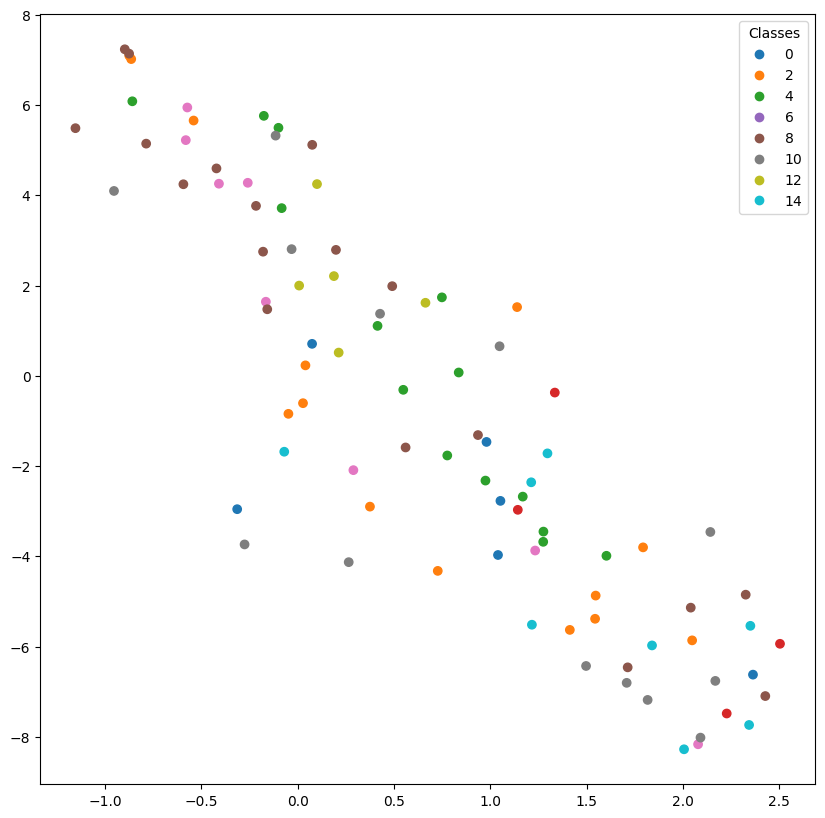

In [51]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_features(features, labels):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab10')
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

# 可視化測試集的特徵分布
plot_features(test_features, test_labels)
